<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/analyse_stability_across_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]


In [3]:
# Read the data. The df_new file has additional information about each sample
# such as the following:
#   - PCOS/Control
#   - Cell type
#   - Dataset they belong to

common_norm_df = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv", index_col=0)
df_new = pd.read_csv("/content/drive/MyDrive/aacb_project/datasets/control_pcos_celltype_mapping.csv")
display(df_new)

,sample_id,PCOS/Control,cell_type,dataset
0,GSM1174425,PCOS,endothelial,GDS4987
1,GSM1174429,PCOS,endothelial,GDS4987
2,GSM1174436,PCOS,endothelial,GDS4987
3,GSM1174427,PCOS,epithelial,GDS4987
4,GSM1174430,PCOS,epithelial,GDS4987
...,...,...,...,...
170,GSM27534,control,theca,GDS1050
171,GSM27543,valproic,theca,GDS1050
172,GSM27546,valproic,theca,GDS1050
173,GSM27548,valproic,theca,GDS1050


In [4]:
# Rearrange the rows in df_new to ensure that the 
position = []
values = list(df_new["sample_id"])
for i,j in enumerate(common_norm_df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

# Merge the two dataframes together
result = pd.merge(common_norm_df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
display(result)

,sample_id,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,...,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS,PCOS/Control,cell_type
0,GSM27536,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.000000,0.060236,0.230814,0.078014,0.119300,1.000000,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.000000,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,...,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.396190,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1,PCOS,theca
1,GSM27537,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.040900,0.038093,0.799387,0.131206,0.118719,0.000000,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.000000,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,...,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.564190,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1,PCOS,theca
2,GSM27538,0.241573,0.446494,0.548203,0.247916,0.033477,1.000000,0.137255,0.457245,0.529493,0.864979,0.321063,0.212610,0.564342,0.124113,0.000000,0.119891,0.000000,0.205272,0.253348,0.610282,1.000000,0.764284,0.762722,0.244444,0.062224,0.227353,0.002710,0.000000,0.338057,0.135464,1.000000,0.452107,0.908008,0.264473,1.000000,0.250620,0.634656,0.218459,0.446225,...,0.390449,0.322581,1.000000,0.691409,0.534772,0.061511,0.709024,0.009294,0.578838,0.166392,0.323344,0.000000,0.183544,0.887850,0.754310,0.677912,0.556818,0.035156,0.000000,0.618792,0.622154,0.575527,0.753191,0.338673,0.245172,0.000000,0.480964,0.317073,0.618557,0.229993,0.712381,0.686747,0.252062,0.371943,0.097902,0.517742,0.673404,1,PCOS,theca
3,GSM27540,0.000000,0.173432,0.000000,0.139978,0.242981,0.000000,0.117647,0.350356,0.761277,0.958612,0.243354,1.000000,0.103006,1.000000,0.585332,0.035422,0.778481,0.864088,0.006696,0.321946,0.977631,0.541706,0.052429,0.422222,0.176384,0.000000,0.439024,0.250000,0.350202,0.324201,0.706619,0.689655,0.372847,0.309933,0.948579,0.000000,1.000000,0.230596,0.000000,...,0.839888,0.612903,0.623574,1.000000,0.633094,0.084359,0.448128,0.589219,0.929461,0.337727,0.160883,0.315079,0.539701,0.000000,0.625000,0.810312,0.000000,1.000000,0.135025,0.000000,0.688000,0.151899,0.555319,0.000000,0.359362,0.120253,0.083756,0.158537,0.000000,0.240081,0.354286,0.778830,0.195234,0.444015,0.132867,0.156452,0.730851,1,PCOS,theca
4,GSM27541,0.723596,0.845018,0.373149,0.446988,0.768898,0.212903,0.352941,1.000000,0.722415,0.571534,0.262440,0.150497,0.178874,0.836879,1.000000,0.169619,0.525316,1.000000,0.444196,0.000000,0.000000,0.461032,0.000000,1.000000,0.516903,0.341622,0.116531,0.125000,0.504049,1.000000,0.265945,0.214559,0.254592,1.000000,0.000000,0.665012,0.440670,0.187412,0.415202,...,1.000000,0.000000,0.273651,0.334021,0.654676,0.557118,0.000000,0.124535,1.000000,0.322900,0.000000,0.246825,1.000000,0.186916,0.362069,0.969764,0.507576,0.136719,0.115385,0.053691,0.950154,0.858228,0.821277,0.819222,0.680101,0.120253,0.621827,0.209350,0.171134,1.000000,0.108190,0.254733,0.000000,0.54

In [6]:
X = common_norm_df[common_norm_df.columns[1:-1]].to_numpy()
X.shape

(175, 1667)

In [7]:
def get_cost_reconstruction(model, k_list=k_list):
    bce_loss = []
    l2_error = []
    output = []
    
    print("Calculating Reconstruction Error for:", model.upper())
    time.sleep(1)
    
    if model == "pca":
        for k in tqdm(k_list):
            model = PCA(n_components=k, random_state=4)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)

    if model == "ica":
        for k in tqdm(k_list):
            model = FastICA(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)

    if model == "nmf":
        for k in tqdm(k_list):
            model = NMF(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)
    
    return bce_loss, l2_error, output

In [8]:
model_list = ["pca", "ica", "nmf"]
bce_loss = []
l2_error = []
reconstruction_list = []

for model in model_list:
    bce, l2, output = get_cost_reconstruction(model)
    bce_loss.append(bce)
    l2_error.append(l2)
    reconstruction_list.append(output)

Calculating Reconstruction Error for: PCA


100%|██████████| 28/28 [00:04<00:00,  6.39it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 28/28 [03:19<00:00,  7.13s/it]


In [9]:
df = pd.DataFrame({'k': k_list, 'pca': bce_loss[0], 'ica': bce_loss[1], 'nmf': bce_loss[2]})
print(df.head())
print(df.shape)

   k       pca       ica       nmf
0  2  0.651077  0.651077  0.650643
1  3  0.662356  0.662356  0.658188
2  4  0.666884  0.666879  0.663417
3  5  0.671462  0.671467  0.671658
4  6  0.678241  0.678237  0.679218
(28, 4)


In [10]:
num_cca_trials = 5
epsilon = 1e-6
threshold = 1e-6

In [17]:
def get_svcca_across_z_stability(z_dict_a, z_dict_b, algorithm, threshold=0.98):
    output_list = []
    for model_a in z_dict_a.keys():
        model_a_df = z_dict_a[model_a]

        for model_b in z_dict_b.keys():
            if model_a != model_b:
                model_b_df = z_dict_b[model_b]

                result = robust_cca_similarity(model_a_df, model_b_df, verbose=False, threshold=threshold)

                output_list.append(np.mean(result["cca_coef1"]))

    # Convert output to pandas dataframe
    return pd.DataFrame(output_list, columns=["svcca_mean_similarity"])

In [11]:
def robust_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=False):
  for trial in range(num_cca_trials):
    try:
      return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns, verbose=verbose)
    except:
      acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      if trial + 1 == num_cca_trials:
        raise

  return return_dict

In [12]:
def positivedef_matrix_sqrt(array):
  w, v = np.linalg.eigh(array)
  wsqrt = np.sqrt(w)
  sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
  return sqrtarray

In [13]:
def get_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=True):
  return_dict = {}

  # compute covariance with numpy function for extra stability
  numx = acts1.shape[0]

  covariance = np.cov(acts1, acts2)
  sigmaxx = covariance[0][0]
  sigmaxy = covariance[0][1]
  sigmayx = covariance[1][0]
  sigmayy = covariance[1][1]

  # rescale covariance to make cca computation more stable
  xmax = np.max(np.abs(sigmaxx))
  ymax = np.max(np.abs(sigmayy))
  sigmaxx /= xmax
  sigmayy /= ymax
  sigmaxy /= np.sqrt(xmax * ymax)
  sigmayx /= np.sqrt(xmax * ymax)

  ([_, sx, vx], [_, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs,
   y_idxs) = compute_ccas(sigmaxx, sigmaxy, sigmayx, sigmayy,
                          verbose)

  # if x_idxs or y_idxs is all false, return_dict has zero entries
  if (not np.any(x_idxs)) or (not np.any(y_idxs)):
    # return create_zero_dict(compute_dirns, acts1.shape[1])
    return create_zero_dict(compute_dirns, 1)

  if compute_dirns:
    # orthonormal directions that are CCA directions
    cca_dirns1 = np.dot(vx, np.dot(invsqrt_xx, acts1[x_idxs]))
    cca_dirns2 = np.dot(vy, np.dot(invsqrt_yy, acts2[y_idxs]))

  # get rid of trailing zeros in the cca coefficients
  idx1 = sum_threshold(sx, threshold)
  idx2 = sum_threshold(sy, threshold)

  return_dict["neuron_coeffs1"] = np.dot(vx, invsqrt_xx)
  return_dict["neuron_coeffs2"] = np.dot(vy, invsqrt_yy)
  return_dict["cca_coef1"] = sx
  return_dict["cca_coef2"] = sy
  return_dict["x_idxs"] = x_idxs
  return_dict["y_idxs"] = y_idxs
  # summary statistics
  return_dict["mean"] = (np.mean(sx[:idx1]), np.mean(sy[:idx2]))
  return_dict["sum"] = (np.sum(sx), np.sum(sy))

  if compute_dirns:
    return_dict["cca_dirns1"] = cca_dirns1
    return_dict["cca_dirns2"] = cca_dirns2

  return return_dict

In [14]:
def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, verbose=True):
  x_idxs = int(sigma_xx >= threshold)
  y_idxs = int(sigma_yy >= threshold)
  numx = 1
  numy = 1

  if numx == 0 or numy == 0:
    return ([0, 0, 0], [0, 0, 0], np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy), x_idxs, y_idxs)

  if verbose:
    print("adding eps to diagonal and taking inverse")
  sigma_xx +=epsilon * np.eye(numx)
  sigma_yy +=epsilon * np.eye(numy)
  inv_xx = np.linalg.pinv(sigma_xx)
  inv_yy = np.linalg.pinv(sigma_yy)

  if verbose:
    print("taking square root")
  invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
  invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

  if verbose:
    print("dot products...")
  arr_x = np.dot(sigma_yx, invsqrt_xx)
  arr_x = np.dot(inv_yy, arr_x)
  arr_x = np.dot(invsqrt_xx, np.dot(sigma_xy, arr_x))
  arr_y = np.dot(sigma_xy, invsqrt_yy)
  arr_y = np.dot(inv_xx, arr_y)
  arr_y = np.dot(invsqrt_yy, np.dot(sigma_yx, arr_y))

  if verbose:
    print("trying to take final svd")
  arr_x_stable = arr_x + epsilon * np.eye(arr_x.shape[0])
  arr_y_stable = arr_y + epsilon * np.eye(arr_y.shape[0])
  try:
      ux, sx, vx = np.linalg.svd(arr_x_stable)
      uy, sy, vy = np.linalg.svd(arr_y_stable)
  except:
      return [0, 0, 0], [0, 0, 0], 0, 0, 0, 0
  sx = np.sqrt(np.abs(sx))
  sy = np.sqrt(np.abs(sy))
  if verbose:
    print("computed everything!")

  return [ux, sx, vx], [uy, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs

In [15]:
def create_zero_dict(compute_dirns, dimension):
  return_dict = {}
  return_dict["mean"] = (np.asarray(0), np.asarray(0))
  return_dict["sum"] = (np.asarray(0), np.asarray(0))
  return_dict["cca_coef1"] = np.asarray(0)
  return_dict["cca_coef2"] = np.asarray(0)
  return_dict["idx1"] = 0
  return_dict["idx2"] = 0

  if compute_dirns:
    return_dict["cca_dirns1"] = np.zeros((1, dimension))
    return_dict["cca_dirns2"] = np.zeros((1, dimension))

  return return_dict

In [16]:
def sum_threshold(array, threshold):
  assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

  for i in range(len(array)):
    if np.sum(array[:i]) / np.sum(array) >= threshold:
      return i

In [22]:
dataset_svcca_results_list = []
for algorithm in model_list:
    for z_a in k_list:
        # Read in the first dictionary
        z_dict_a = df.loc[df['k'] == z_a]
        
        # Only compare to higher z dimensions
        z_bs = [x for x in k_list if x > z_a]

        for z_b in z_bs:

            # Read in the second dictionary
            z_dict_b = df.loc[df['k'] == z_b]

            # print("Calculating... algorithm {}, and dimension {} vs. {}".format(algorithm, z_a, z_b))

            # Perform across z dimension SVCCA
            svcca_out = get_svcca_across_z_stability(
                # z_dict_a=z_dict_a,
                # z_dict_b=z_dict_b,
                z_dict_a=df,
                z_dict_b=df,
                algorithm=algorithm,
            )

            # Append info to the output dataframe
            svcca_out = svcca_out.assign(
                algorithm=algorithm,
                z_dim_a=z_a,
                z_dim_b=z_b
            )

            # Append to final list
            dataset_svcca_results_list.append(svcca_out)

In [24]:
svcca_results_df = pd.concat(dataset_svcca_results_list)
svcca_results_df.columns = ['svcca_mean_similarity', 'algorithm', 'z_dim_a', 'z_dim_b']
svcca_results_df.head(2)

,svcca_mean_similarity,algorithm,z_dim_a,z_dim_b
0,0.511744,pca,2,3
1,0.369343,pca,2,3


In [46]:
mydf = svcca_results_df.copy(deep=True)
ans = [pd.DataFrame(y) for x, y in mydf.groupby('algorithm', as_index=False)]
mydf_ica = ans[0].drop('algorithm', axis=1)
mydf_nmf = ans[1].drop('algorithm', axis=1)
mydf_pca = ans[2].drop('algorithm', axis=1)

In [52]:
k_pairs = []
for z_a in k_list:
    z_bs = [x for x in k_list if x > z_a]
    for z_b in z_bs:
        k_pairs.append((z_a, z_b))

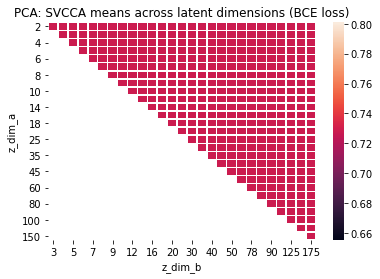

In [95]:
# pca
ans_pca = [pd.DataFrame(y) for x, y in mydf_pca.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
pca_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_pca]
pca_across_k_means = pd.concat(pca_across_k_means)
fig = sns.heatmap(pca_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('PCA: SVCCA means across latent dimensions (BCE loss)')
figure = fig.get_figure()
figure.savefig('pca_across_k_means_bce_loss.png', dpi=400)

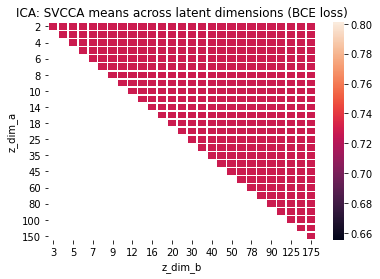

In [96]:
# ica
ans_ica = [pd.DataFrame(y) for x, y in mydf_ica.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
ica_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_ica]
ica_across_k_means = pd.concat(ica_across_k_means)
fig = sns.heatmap(ica_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('ICA: SVCCA means across latent dimensions (BCE loss)')
figure = fig.get_figure()    
figure.savefig('ica_across_k_means_bce_loss.png', dpi=400)

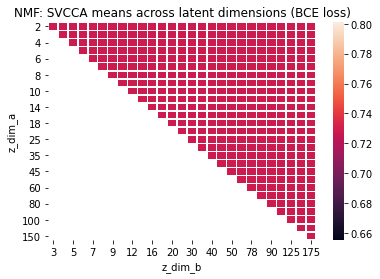

In [97]:
# nmf
ans_nmf = [pd.DataFrame(y) for x, y in mydf_nmf.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
nmf_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_nmf]
nmf_across_k_means = pd.concat(nmf_across_k_means)
fig = sns.heatmap(nmf_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('NMF: SVCCA means across latent dimensions (BCE loss)')
figure = fig.get_figure()    
figure.savefig('nmf_across_k_means_bce_loss.png', dpi=400)

In [27]:
out_file = os.path.join('results', 'svcca_across_z_mean_correlation.tsv.gz')
svcca_results_df.to_csv(out_file, sep='\t', index=False, compression='gzip')

In [98]:
df = pd.DataFrame({'k': k_list, 'pca': l2_error[0], 'ica': l2_error[1], 'nmf': l2_error[2]})
print(df.head())
print(df.shape)

   k         pca         ica         nmf
0  2  136.616459  136.616459  138.540906
1  3  132.103318  132.103318  133.759251
2  4  128.453513  128.453513  130.354917
3  5  125.483532  125.483531  127.845929
4  6  122.839029  122.839027  125.219715
(28, 4)


In [99]:
dataset_svcca_results_list = []
for algorithm in model_list:
    for z_a in k_list:
        # Read in the first dictionary
        z_dict_a = df.loc[df['k'] == z_a]
        
        # Only compare to higher z dimensions
        z_bs = [x for x in k_list if x > z_a]

        for z_b in z_bs:

            # Read in the second dictionary
            z_dict_b = df.loc[df['k'] == z_b]

            # print("Calculating... algorithm {}, and dimension {} vs. {}".format(algorithm, z_a, z_b))

            # Perform across z dimension SVCCA
            svcca_out = get_svcca_across_z_stability(
                # z_dict_a=z_dict_a,
                # z_dict_b=z_dict_b,
                z_dict_a=df,
                z_dict_b=df,
                algorithm=algorithm,
            )

            # Append info to the output dataframe
            svcca_out = svcca_out.assign(
                algorithm=algorithm,
                z_dim_a=z_a,
                z_dim_b=z_b
            )

            # Append to final list
            dataset_svcca_results_list.append(svcca_out)

In [100]:
svcca_results_df = pd.concat(dataset_svcca_results_list)
svcca_results_df.columns = ['svcca_mean_similarity', 'algorithm', 'z_dim_a', 'z_dim_b']
svcca_results_df.head(2)

,svcca_mean_similarity,algorithm,z_dim_a,z_dim_b
0,0.977101,pca,2,3
1,0.600078,pca,2,3


In [101]:
mydf = svcca_results_df.copy(deep=True)
ans = [pd.DataFrame(y) for x, y in mydf.groupby('algorithm', as_index=False)]
mydf_ica = ans[0].drop('algorithm', axis=1)
mydf_nmf = ans[1].drop('algorithm', axis=1)
mydf_pca = ans[2].drop('algorithm', axis=1)

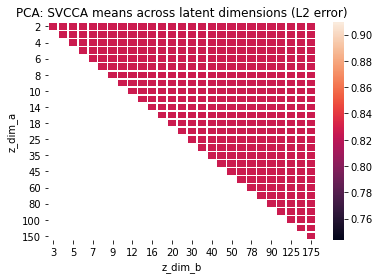

In [102]:
# pca
ans_pca = [pd.DataFrame(y) for x, y in mydf_pca.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
pca_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_pca]
pca_across_k_means = pd.concat(pca_across_k_means)
fig = sns.heatmap(pca_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('PCA: SVCCA means across latent dimensions (L2 error)')
figure = fig.get_figure()
figure.savefig('pca_across_k_means_l2_error.png', dpi=400)

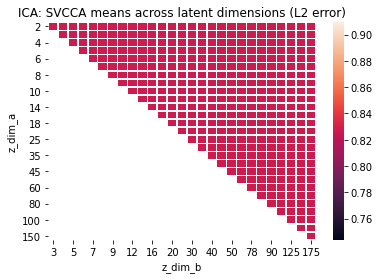

In [103]:
# ica
ans_ica = [pd.DataFrame(y) for x, y in mydf_ica.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
ica_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_ica]
ica_across_k_means = pd.concat(ica_across_k_means)
fig = sns.heatmap(ica_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('ICA: SVCCA means across latent dimensions (L2 error)')
figure = fig.get_figure()    
figure.savefig('ica_across_k_means_l2_error.png', dpi=400)

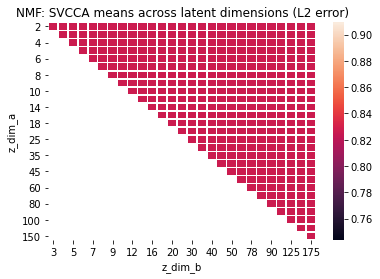

In [104]:
# nmf
ans_nmf = [pd.DataFrame(y) for x, y in mydf_nmf.groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
nmf_across_k_means = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_nmf]
nmf_across_k_means = pd.concat(nmf_across_k_means)
fig = sns.heatmap(nmf_across_k_means.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), linewidths=.5)
fig.set_title('NMF: SVCCA means across latent dimensions (L2 error)')
figure = fig.get_figure()    
figure.savefig('nmf_across_k_means_l2_error.png', dpi=400)